In [2]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.feature_selection import VarianceThreshold
from sklearn.svm import SVR
import seaborn as sns
import io
import urllib.request
import matplotlib.pyplot as plt
import os
import collections
import re
import json
import xml.etree.ElementTree as ET
import zipfile
import math

%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
    
import matplotlib.pyplot as plt

In [25]:
data=pd.read_csv('../../DrugDatabasesTools/Chembl/Chembl.csv')
data.head()

C:\Users\joaof\Miniconda3\envs\py36\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (28,29) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,molregno,pref_name,chembl_id,max_phase,therapeutic_flag,dosed_ingredient,structure_type,chebi_par_id,molecule_type,first_approval,...,full_mwt,aromatic_rings,heavy_atoms,num_alerts,qed_weighted,mw_monoisotopic,full_molformula,hba_lipinski,hbd_lipinski,num_lipinski_ro5_violations
0,170,NaN,CHEMBL263777,0,0,0,MOL,NaN,Small molecule,NaN,...,588.82,3.0,43.0,1.0,0.16,588.4039,C36H52N4O3,7.0,4.0,1.0
1,184,NaN,CHEMBL6227,0,0,0,MOL,NaN,Small molecule,NaN,...,602.85,3.0,44.0,1.0,0.14,602.4196,C37H54N4O3,7.0,4.0,1.0
2,185,NaN,CHEMBL6242,0,0,0,MOL,NaN,Small molecule,NaN,...,588.82,3.0,43.0,1.0,0.16,588.4039,C36H52N4O3,7.0,4.0,1.0
3,197,NaN,CHEMBL448105,0,0,0,BOTH,NaN,Protein,NaN,...,851.00,1.0,60.0,1.0,0.04,850.4913,C39H66N10O11,21.0,16.0,2.0
4,198,SC-58272,CHEMBL6269,0,0,0,MOL,NaN,Small molecule,NaN,...,596.80,2.0,43.0,1.0,0.16,596.4050,C33H52N6O4,10.0,6.0,1.0


In [ ]:
data.dtypes

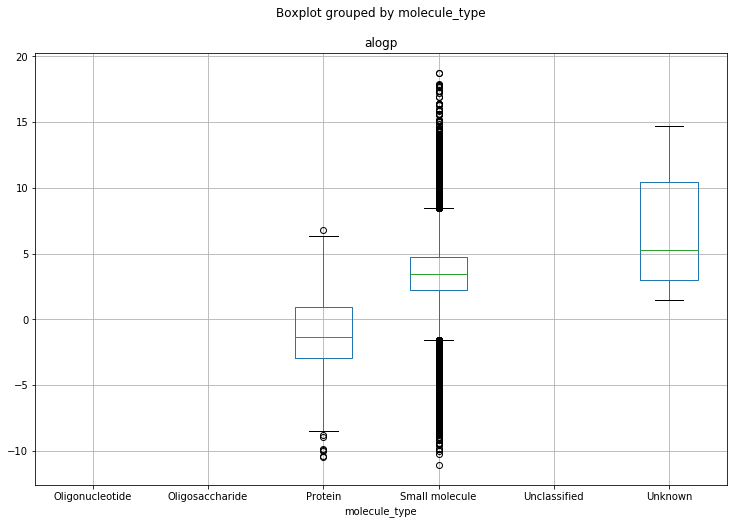

In [3]:
data.boxplot('alogp', by='molecule_type', figsize=(12, 8))


In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

mod = ols('alogp ~ molecule_type',
                data=data).fit()
                
aov_table = sm.stats.anova_lm(mod, typ=2)

print(aov_table.iloc[0,0])

aov_table

In [17]:
def get_explainibility_for_all_columns(data, limit=0):
    results={}
    for element in data.columns[0:limit]:
        if data[element].nunique()<500:
            model='alogp ~ '+element
            mod = ols(model,
                    data=data).fit()

            aov_table = sm.stats.anova_lm(mod, typ=2)

            results[element]=aov_table.iloc[0,0]

    return results
get_explainibility_for_all_columns(data,limit=20)

C:\Users\joaof\Miniconda3\envs\py36\lib\site-packages\statsmodels\base\model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)
C:\Users\joaof\Miniconda3\envs\py36\lib\site-packages\statsmodels\base\model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)


{'max_phase': 2405.804156768931,
 'therapeutic_flag': 1627.9401711574656,
 'dosed_ingredient': 1879.6256340937366,
 'structure_type': 53289.67220342529,
 'molecule_type': 28.062371534100162,
 'first_approval': 86.01084333714148,
 'oral': 735.9845235174366,
 'parenteral': 1616.1857545513863,
 'topical': 445.0680974820049,
 'black_box_warning': 364.8604703253763,
 'natural_product': 3632.846875076524,
 'first_in_class': 2795.325471018739,
 'chirality': 2288.5974907967284,
 'prodrug': 2820.6248932805647,
 'inorganic_flag': 2868.3785315680366,
 'usan_year': 151.6751726436156}

In [63]:
def xMlr(df,target,frac=0.7,cv=10):
    i=0
    mse=0
    score=0
    while i<cv:
        np.random.seed(seed=123)
        pka_data_train=df.sample(frac=0.7,random_state=200)
        pka_data_test=df.drop(pka_data_train.index)

        pka_data_x=df.drop(columns=[target])
        pka_data_y=df[target]

        pka_data_x_train=df.drop(columns=[target])
        pka_data_y_train=df[target]

        pka_data_x_test=df.drop(columns=[target])
        pka_data_y_test=df[target]
        regr = linear_model.LinearRegression()
        regr.fit(pka_data_x_train, pka_data_y_train)
        #print(regr.coef_)
        mse+=(np.mean((regr.predict( pka_data_x_test)-pka_data_y_test)**2))
        score+=regr.score(pka_data_x_test, pka_data_y_test)
        i+=1
    rmse = np.sqrt(mse/cv)
    return mse/cv, score/cv, regr,rmse

In [64]:
data_for_lm=data[['natural_product','chirality','prodrug','inorganic_flag','structure_type_0','structure_type_1','structure_type_2','alogp']]
data_for_lm.dropna(inplace=True)

xMlr(data_for_lm,'alogp')


C:\Users\joaof\Miniconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(4.819537479798037,
 0.042562467841175455,
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
 2.195344501393355)

In [60]:
predict=model.predict(data_for_lm.drop(columns='alogp'))


model.

TypeError: score() missing 2 required positional arguments: 'X' and 'y'

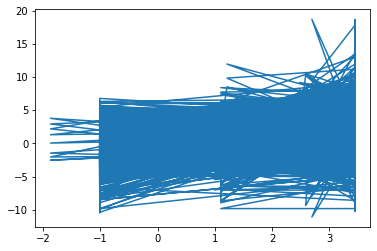

In [56]:
plt.plot(predict,data_for_lm.alogp)

In [26]:
from sklearn.preprocessing import LabelEncoder
le_color = LabelEncoder()
le_make = LabelEncoder()
data['structure_type_encoded'] = le_color.fit_transform(data.structure_type)
#df['make_encoded'] = le_make.fit_transform(df.make)

from sklearn.preprocessing import OneHotEncoder
color_ohe = OneHotEncoder()
make_ohe = OneHotEncoder()
X = color_ohe.fit_transform(data.structure_type_encoded.values.reshape(-1,1)).toarray()
#Xm = make_ohe.fit_transform(df.make_encoded.values.reshape(-1,1)).toarray()

dfOneHot = pd.DataFrame(X, columns = ["structure_type_"+str(int(i)) for i in range(X.shape[1])])
data = pd.concat([data, dfOneHot], axis=1)
#dfOneHot = pd.DataFrame(Xm, columns = ["Make"+str(int(i)) for i in range(X.shape[1])])
#df = pd.concat([df, dfOneHot], axis=1)
data.head()

C:\Users\joaof\Miniconda3\envs\py36\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


,molregno,pref_name,chembl_id,max_phase,therapeutic_flag,dosed_ingredient,structure_type,chebi_par_id,molecule_type,first_approval,...,qed_weighted,mw_monoisotopic,full_molformula,hba_lipinski,hbd_lipinski,num_lipinski_ro5_violations,structure_type_encoded,structure_type_0,structure_type_1,structure_type_2
0,170,NaN,CHEMBL263777,0,0,0,MOL,NaN,Small molecule,NaN,...,0.16,588.4039,C36H52N4O3,7.0,4.0,1.0,1,0.0,1.0,0.0
1,184,NaN,CHEMBL6227,0,0,0,MOL,NaN,Small molecule,NaN,...,0.14,602.4196,C37H54N4O3,7.0,4.0,1.0,1,0.0,1.0,0.0
2,185,NaN,CHEMBL6242,0,0,0,MOL,NaN,Small molecule,NaN,...,0.16,588.4039,C36H52N4O3,7.0,4.0,1.0,1,0.0,1.0,0.0
3,197,NaN,CHEMBL448105,0,0,0,BOTH,NaN,Protein,NaN,...,0.04,850.4913,C39H66N10O11,21.0,16.0,2.0,0,1.0,0.0,0.0
4,198,SC-58272,CHEMBL6269,0,0,0,MOL,NaN,Small molecule,NaN,...,0.16,596.4050,C33H52N6O4,10.0,6.0,1.0,1,0.0,1.0,0.0


In [45]:

data_for_lm.isnull().sum()

C:\Users\joaof\Miniconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


natural_product     0
chirality           0
prodrug             0
inorganic_flag      0
structure_type_0    0
structure_type_1    0
structure_type_2    0
alogp               0
dtype: int64